### 自回归模型
输入数据的数量，$x_{t-1}, \ldots, x_1$输入本身因$t$而异。 也就是说，输入数据的数量这个数字将会随着我们遇到的数据量的增加而增加， 因此需要一个近似方法来使这个计算变得容易处理。 本章后面的大部分内容将围绕着如何有效估计$P(x_t \mid x_{t-1}, \ldots, x_1)$展开。 简单地说，它归结为以下两种策略。

1.假设在现实情况下相当长的序列$x_{t-1}, \ldots, x_1$可能是不必要的， 因此我们只需要满足某个长度为$\tau$的时间跨度，即使用观测序列$x_{t-1}, \ldots, x_{t-\tau}$。 当下获得的最直接的好处就是参数的数量总是不变的， 至少在$t > \tau$时如此，这就使我们能够训练一个上面提及的深度网络。 这种模型被称为自回归模型（autoregressive models）， 因为它们是对自己执行回归。

2.保留一些对过去观测的总结$h_t$，并且同时更新预测$\hat{x}_t$和总结$h_t$。这就产生了基于$\hat{x}_t = P(x_t \mid h_{t})$估计$x_\tau$，以及公式$h_t = g(h_{t-1}, x_{t-1})$更新的模型。 由于$h_t$从未被观测到，这类模型也被称为 隐变量自回归模型（latent autoregressive models）。

整个序列的估计值都将通过以下的方式获得：

$P(x_1, \ldots, x_T) = \prod_{t=1}^T P(x_t \mid x_{t-1}, \ldots, x_1).$

### 马尔可夫模型

在自回归模型的近似法中，我们使用$x_{t-1}, \ldots, x_{t-\tau}$而不是$x_{t-1}, \ldots, x_1$来估计。只要这种是近似精确的，我们就说序列满足马尔可夫条件（Markov condition）。 特别是，如果$\tau = 1$，得到一个一阶马尔可夫模型（first-order Markov model），$P(x)$由下式给出：

$P(x_1, \ldots, x_T) = \prod_{t=1}^T P(x_t \mid x_{t-1}) \text{ 当 } P(x_1 \mid x_0) = P(x_1).$

当假设$x_t$仅是离散值时，这样的模型特别棒， 因为在这种情况下，使用动态规划可以沿着马尔可夫链精确地计算结果。 例如，我们可以高效地计算$P(x_{t+1} \mid x_{t-1})$：

$\begin{split}\begin{aligned}
P(x_{t+1} \mid x_{t-1})
&= \frac{\sum_{x_t} P(x_{t+1}, x_t, x_{t-1})}{P(x_{t-1})}\\
&= \frac{\sum_{x_t} P(x_{t+1} \mid x_t, x_{t-1}) P(x_t, x_{t-1})}{P(x_{t-1})}\\
&= \sum_{x_t} P(x_{t+1} \mid x_t) P(x_t \mid x_{t-1})
\end{aligned}\end{split}$

利用这一事实，我们只需要考虑过去观察中的一个非常短的历史：$P(x_{t+1} \mid x_t, x_{t-1}) = P(x_{t+1} \mid x_t)$。

In [ ]:
%matplotlib inline
!pip install d2l
!pip install matplotlib==3.0.0
import torch
from torch import nn
from d2l import torch as d2l



首先生成一些数据：使用正弦函数和一些可加性噪声来生成序列数据，时间步为$1, 2, \ldots, 1000$。

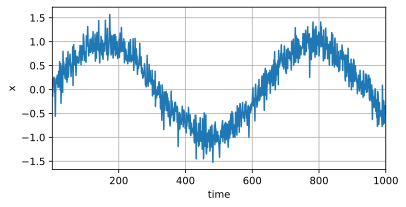

In [3]:
T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

接下来，将这个序列转换为模型的“特征－标签”（feature-label）对。 基于嵌入维度$\tau$，将数据映射为数据对$y_t = x_t$和$\mathbf{x}_t = [x_{t-\tau}, \ldots, x_{t-1}]$。 你可能已经注意到，这比提供的数据样本少了$\tau$个， 因为没有足够的历史记录来描述前$\tau$个数据样本。 一个简单的解决办法是：如果拥有足够长的序列就丢弃这几项； 另一个方法是用零填充序列。 在这里，我们仅使用前600个“特征－标签”对进行训练。

In [4]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

使用一个相当简单的架构训练模型： 一个拥有两个全连接层的多层感知机，ReLU激活函数和平方损失。

In [5]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

In [6]:
# 训练函数
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.053185
epoch 2, loss: 0.052495
epoch 3, loss: 0.049387
epoch 4, loss: 0.047736
epoch 5, loss: 0.046689


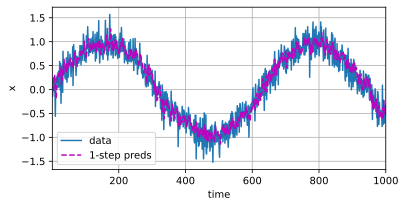

In [7]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

单步预测效果不错。 即使这些预测的时间步超过了$600+4$（n_train + tau）， 其结果看起来仍然是可信的。 然而有一个小问题：如果数据观察序列的时间步只到$604$， 我们需要一步一步地向前迈进：

$\begin{split}\hat{x}_{605} = f(x_{601}, x_{602}, x_{603}, x_{604}), \\
\hat{x}_{606} = f(x_{602}, x_{603}, x_{604}, \hat{x}_{605}), \\
\hat{x}_{607} = f(x_{603}, x_{604}, \hat{x}_{605}, \hat{x}_{606}),\\
\hat{x}_{608} = f(x_{604}, \hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}),\\
\hat{x}_{609} = f(\hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}, \hat{x}_{608}),\\
\ldots\end{split}$
 
通常，对于直到$x_t$的观测序列，其在时间步$t+k$处的预测输出$\hat{x}_{t+k}$称为$k$步预测（-step-ahead-prediction）。 由于我们的观察已经到了$x_{604}$，它的步预测是$\hat{x}_{604+k}$
。 换句话说，我们必须使用我们自己的预测（而不是原始数据）来进行多步预测。

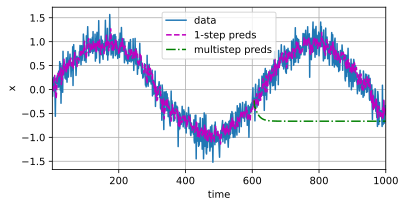

In [8]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

如上面的例子所示，绿线的预测显然并不理想。 经过几个预测步骤之后，预测的结果很快就会衰减到一个常数。 为什么这个算法效果这么差呢？事实是由于错误的累积： 假设在步骤$1$之后，我们积累了一些错误$\epsilon_1 = \bar\epsilon$
。 于是，步骤$2$的输入被扰动了$\epsilon_1$， 结果积累的误差是依照次序的$\epsilon_2 = \bar\epsilon + c \epsilon_1$
， 其中为某个常数，后面的预测误差依此类推。 因此误差可能会相当快地偏离真实的观测结果。 例如，未来小时的天气预报往往相当准确， 但超过这一点，精度就会迅速下降。 

基于$k = 1, 4, 16, 64$，通过对整个序列预测的计算， 让我们更仔细地看一下步预测的困难。

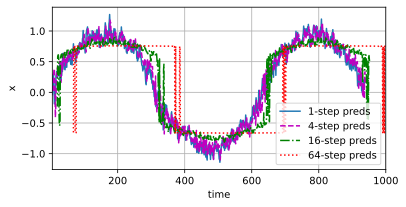

In [9]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))